In [ ]:
# Install required libraries (uncomment if not already installed)
# !pip install scikit-learn seaborn pandas matplotlib

# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")  # ignore warning clutter

# Set default figure size for plots
plt.rcParams["figure.figsize"] = (8, 5)


In [ ]:
# 1. Load dataset
df = pd.read_csv("/content/heart_synthetic_predictive.csv")
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,57.658466,M,ASY,170.460597,243.086785,0,Normal,132.953771,Y,1.897371,Flat,1
1,43.697962,F,ASY,111.286828,211.161652,0,Normal,160.210306,N,0.382932,Up,0
2,37.846027,F,ATA,111.565687,123.468790,0,Normal,105.501643,N,0.620981,Up,0
3,65.977205,F,ATA,127.410501,214.832810,0,LVH,77.207587,Y,1.751398,Down,1
4,42.792336,M,ATA,125.635470,204.436904,0,Normal,116.980128,N,0.227809,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,59.316705,F,NAP,133.387652,223.598498,0,LVH,123.044586,Y,1.444326,Flat,1
49996,58.787237,M,ATA,94.418012,172.405877,0,ST,148.941899,N,1.586602,Up,0
49997,39.583817,M,TA,90.000000,261.569558,0,Normal,163.892520,N,0.000000,Up,0
49998,33.556784,M,ATA,104.356814,184.996367,0,Normal,139.070752,N,0.598998,Up,0


In [ ]:
def preprocess_data(file_path, target_col="HeartDisease"):
    """
    ✅ Step 1: Load data
    ✅ Step 2: Replace '?' with NaN
    ✅ Step 3: Impute missing values (mean for numbers, mode for categoricals)
    ✅ Step 4: Encode categorical features using LabelEncoder
    ✅ Step 5: Scale numerical features between 0-1 (except target column)
    ✅ Step 6: Return cleaned dataset + column info
    """

    # Load dataset
    df = pd.read_csv(file_path)

    # Replace '?' placeholders with NaN
    df.replace('?', np.nan, inplace=True)

    # Separate numeric and categorical columns
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

    # Fill missing values
    numeric_imputer = SimpleImputer(strategy='mean')       # mean for numeric
    categorical_imputer = SimpleImputer(strategy='most_frequent')  # mode for categorical
    df[numerical_cols] = numeric_imputer.fit_transform(df[numerical_cols])
    if categorical_cols:
        df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Scale numerical features (skip target column if numeric)
    features_to_scale = numerical_cols.copy()
    if target_col in features_to_scale:
        features_to_scale.remove(target_col)

    scaler = MinMaxScaler()
    if features_to_scale:
        df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

    return df, numerical_cols, categorical_cols, label_encoders


In [ ]:
# Apply preprocessing
df, numerical_cols, categorical_cols, label_encoders = preprocess_data("/content/heart_synthetic_predictive.csv", target_col="HeartDisease")

# ℹ Dataset summary
print("Data is now ready for Machine Learning models!")
print("Shape of dataset:", df.shape)
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols[:10], "..." if len(categorical_cols) > 10 else "")
df.head()

Data is now ready for Machine Learning models!
Shape of dataset: (50000, 12)
Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] 


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,0.627641,1,0,0.731460,0.476956,0.0,1,0.521098,1,0.474343,1,1.0
1,0.394966,0,0,0.193517,0.370539,0.0,1,0.715788,0,0.095733,2,0.0
2,0.297434,0,1,0.196052,0.078229,0.0,1,0.325012,0,0.155245,2,0.0
3,0.766287,0,1,0.340095,0.382776,0.0,0,0.122911,1,0.437849,0,1.0
4,0.379872,1,1,0.323959,0.348123,0.0,1,0.407001,0,0.056952,2,0.0


In [ ]:
# Define target variable
target = "HeartDisease"
assert target in df.columns, f"Target column '{target}' not found!"

# Features (X) = all columns except target
X = df.drop(columns=[target])
y = df[target].astype(int)

# Split into training (70%) & testing (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (35000, 11)  Test shape: (15000, 11)


In [ ]:
# Try KNN with k=1...6
for k in range(1, 7):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print(f"\n=== KNN (k={k}) ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")



=== KNN (k=1) ===
Confusion Matrix:
 [[7079  437]
 [ 492 6992]]
Accuracy: 93.81 %

=== KNN (k=2) ===
Confusion Matrix:
 [[7329  187]
 [ 787 6697]]
Accuracy: 93.51 %

=== KNN (k=3) ===
Confusion Matrix:
 [[7193  323]
 [ 439 7045]]
Accuracy: 94.92 %

=== KNN (k=4) ===
Confusion Matrix:
 [[7298  218]
 [ 607 6877]]
Accuracy: 94.5 %

=== KNN (k=5) ===
Confusion Matrix:
 [[7201  315]
 [ 437 7047]]
Accuracy: 94.99 %

=== KNN (k=6) ===
Confusion Matrix:
 [[7281  235]
 [ 554 6930]]
Accuracy: 94.74 %


In [ ]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred_dt = dtc.predict(X_test)

print("\n=== Decision Tree ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Accuracy:", round(accuracy_score(y_test, y_pred_dt) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))



=== Decision Tree ===
Confusion Matrix:
 [[7002  514]
 [ 501 6983]]
Accuracy: 93.23 %
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      7516
           1       0.93      0.93      0.93      7484

    accuracy                           0.93     15000
   macro avg       0.93      0.93      0.93     15000
weighted avg       0.93      0.93      0.93     15000



In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n=== Random Forest ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))



=== Random Forest ===
Confusion Matrix:
 [[7216  300]
 [ 288 7196]]
Accuracy: 96.08 %
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      7516
           1       0.96      0.96      0.96      7484

    accuracy                           0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000



In [ ]:
# SVM with different kernels
for kernel in ['linear', 'rbf', 'poly']:
    svm_model = SVC(kernel=kernel, C=1, gamma='scale')
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)

    print(f"\n=== SVM (kernel={kernel}) ===")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
    print("Accuracy:", round(accuracy_score(y_test, y_pred_svm) * 100, 2), "%")
    print("Classification Report:\n", classification_report(y_test, y_pred_svm))



=== SVM (kernel=linear) ===
Confusion Matrix:
 [[7167  349]
 [ 387 7097]]
Accuracy: 95.09 %
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      7516
           1       0.95      0.95      0.95      7484

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000


=== SVM (kernel=rbf) ===
Confusion Matrix:
 [[7234  282]
 [ 297 7187]]
Accuracy: 96.14 %
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      7516
           1       0.96      0.96      0.96      7484

    accuracy                           0.96     15000
   macro avg       0.96      0.96      0.96     15000
weighted avg       0.96      0.96      0.96     15000


=== SVM (kernel=poly) ===
Confusion Matrix:
 [[7248  268]
 [ 313 7171]]
Accuracy: 96.13 %
Classification Report:
 

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
print("\n=== Logistic Regression ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Naïve Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("\n=== Naïve Bayes ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Accuracy:", round(accuracy_score(y_test, y_pred_nb) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))


=== Logistic Regression ===
Confusion Matrix:
 [[7156  360]
 [ 383 7101]]
Accuracy: 95.05 %
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      7516
           1       0.95      0.95      0.95      7484

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000


=== Naïve Bayes ===
Confusion Matrix:
 [[7126  390]
 [ 324 7160]]
Accuracy: 95.24 %
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      7516
           1       0.95      0.96      0.95      7484

    accuracy                           0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000



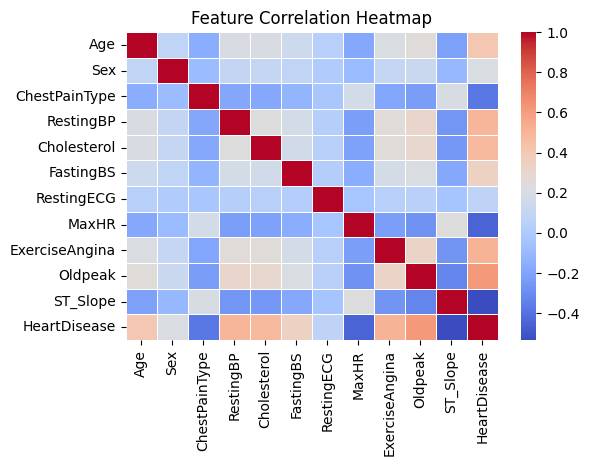

In [ ]:
# 1️ Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


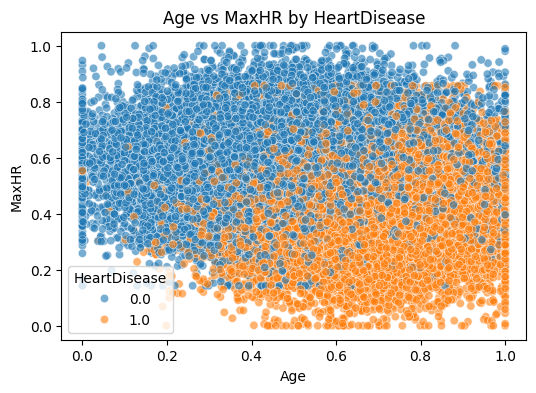

In [ ]:
# 2️ Scatter Plot: Age vs MaxHR vs HeartDisease
if all(col in df.columns for col in ["Age", "MaxHR", "HeartDisease"]):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x='Age', y='MaxHR', hue='HeartDisease', alpha=0.6)
    plt.title("Age vs MaxHR by HeartDisease")
    plt.show()

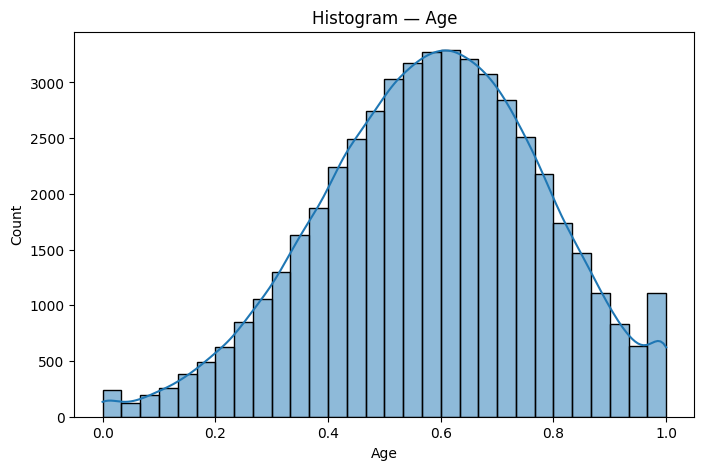

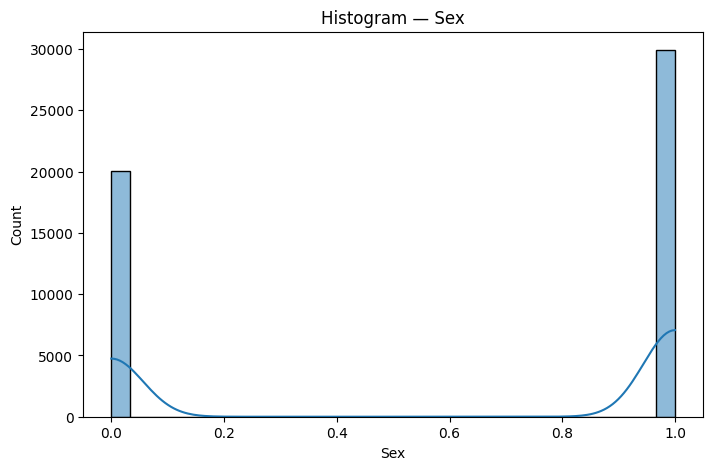

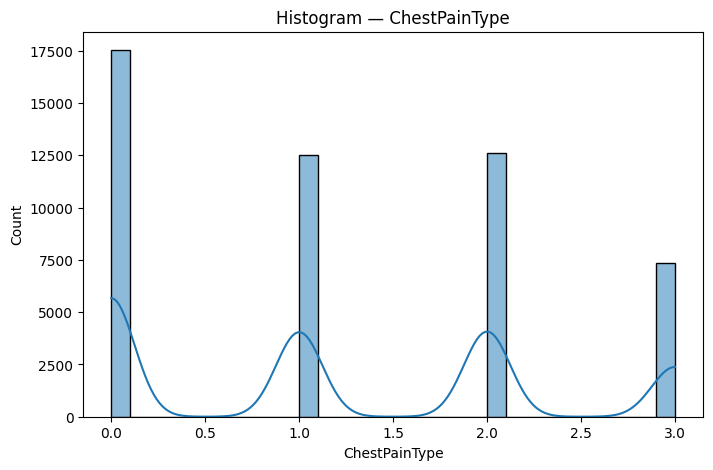

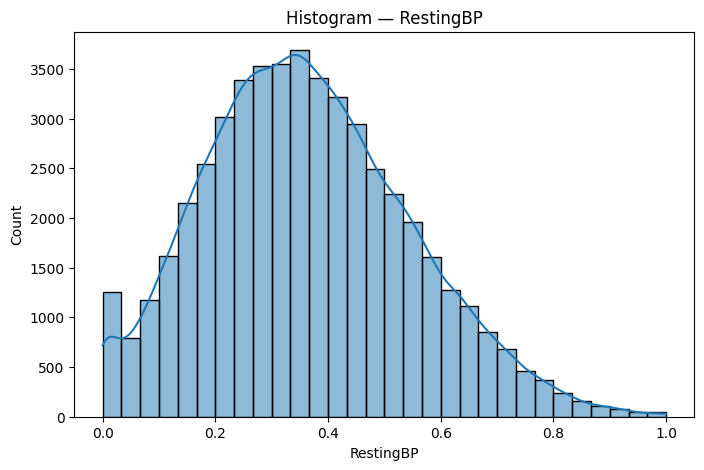

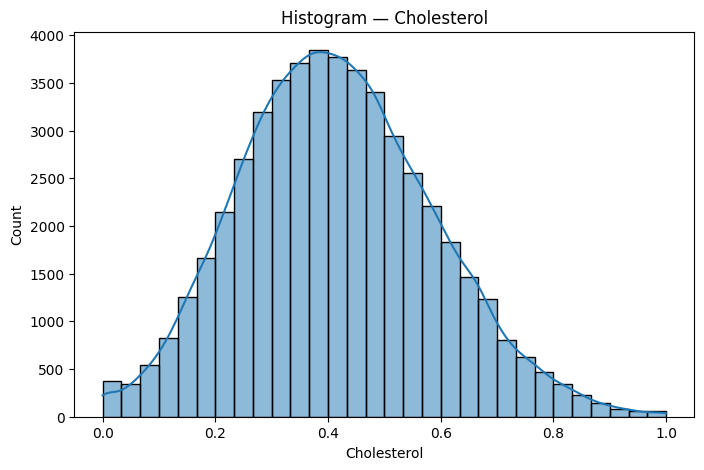

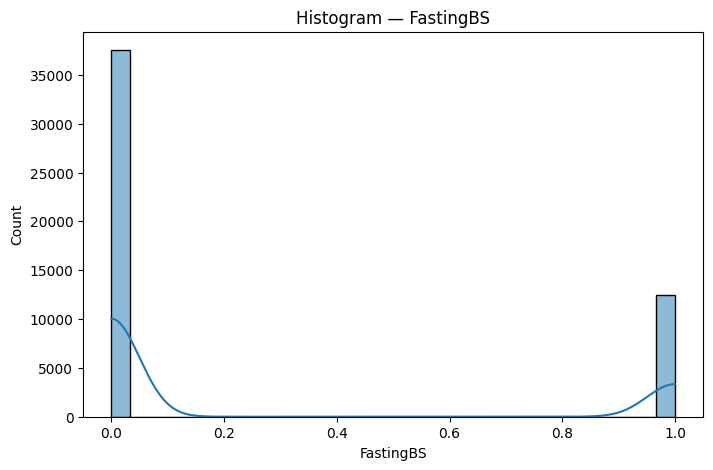

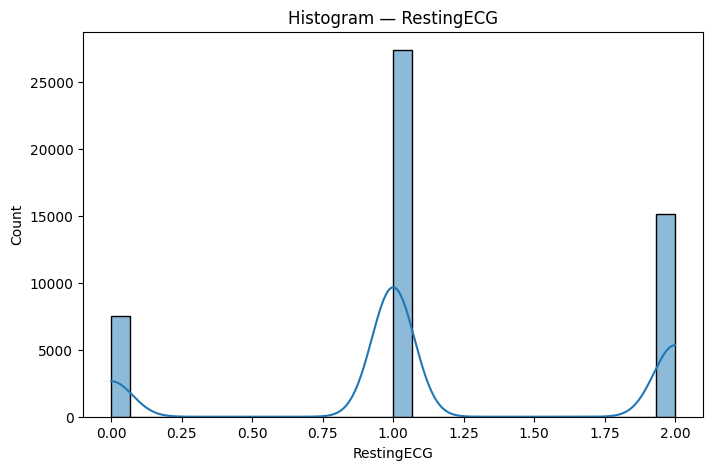

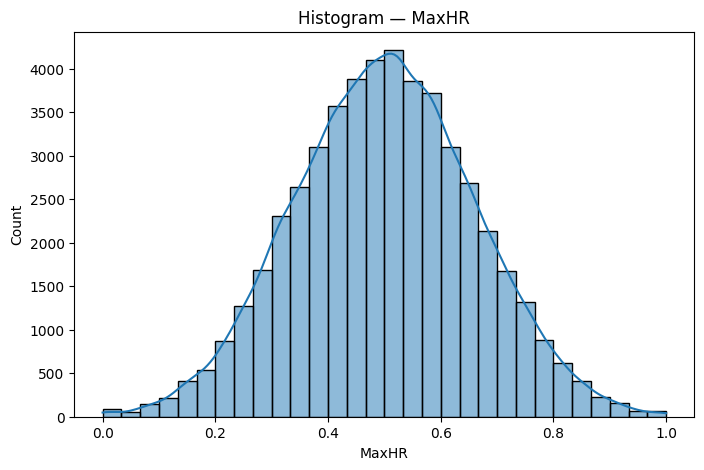

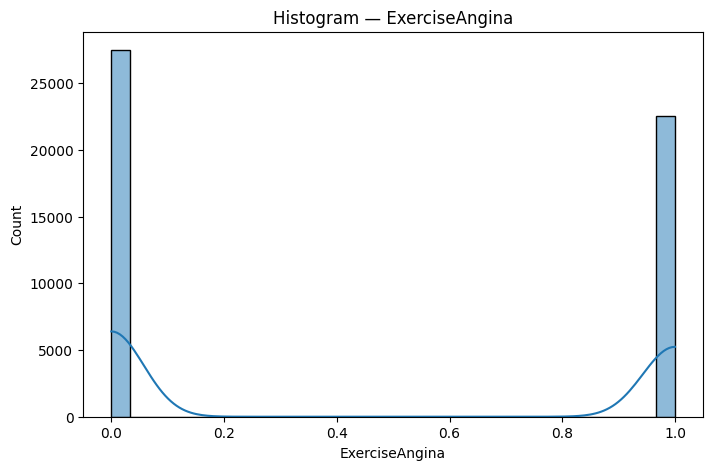

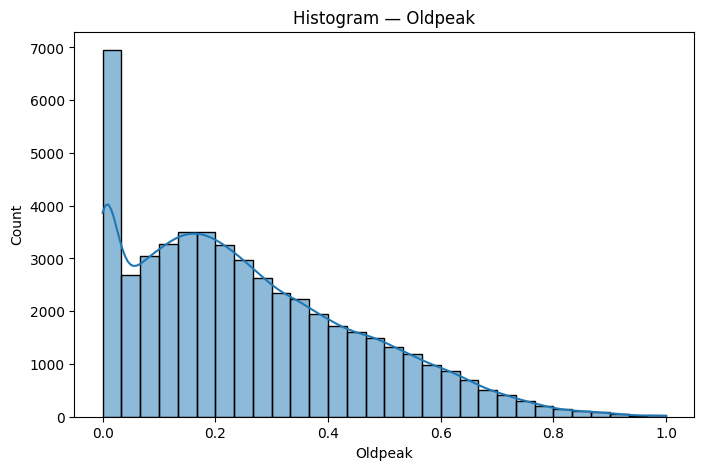

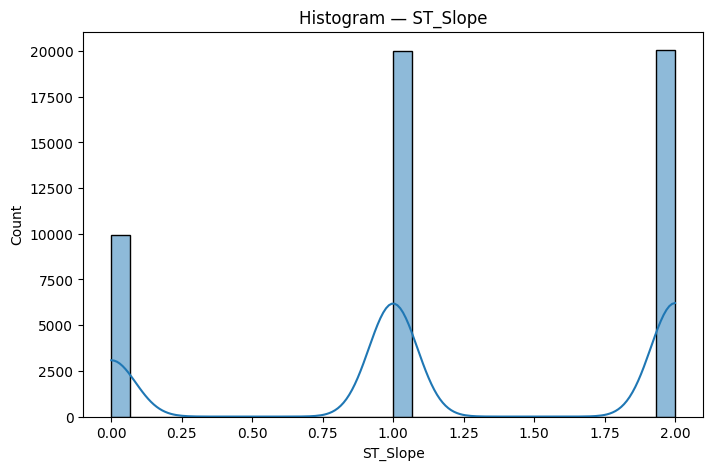

In [ ]:
# 3️ Histograms of numeric features
for col in [c for c in df.select_dtypes(include=['number']).columns if c != target]:
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Histogram — {col}")
    plt.show()

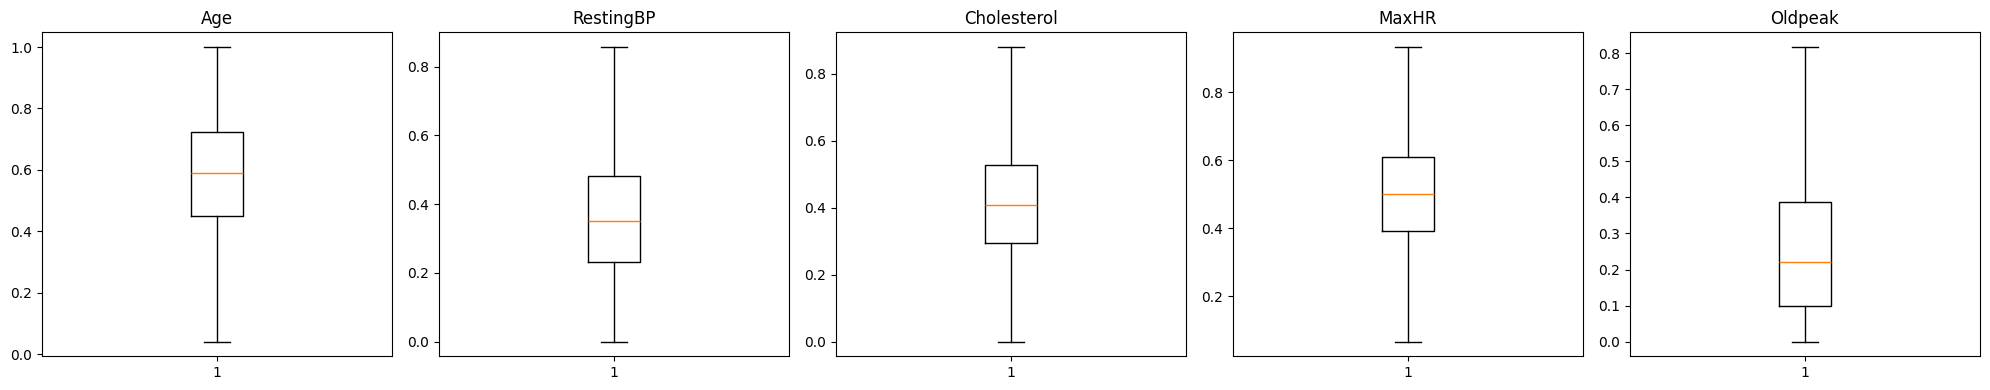

In [ ]:
# 4️ Box Plots (without outliers) for key features
numerical_columns = [c for c in ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak'] if c in df.columns]
if numerical_columns:
    fig, axes = plt.subplots(1, len(numerical_columns), figsize=(4*len(numerical_columns), 4))
    if len(numerical_columns) == 1:
        axes = [axes]
    for ax, col in zip(axes, numerical_columns):
        data = pd.to_numeric(df[col], errors='coerce').dropna()
        ax.boxplot(data, showfliers=False)
        ax.set_title(col)
    plt.tight_layout()
    plt.show()



In [ ]:
print("Analysis completed successfully!")

Analysis completed successfully!


In [32]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]

# Convert categorical columns to numeric (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Final trained model (Random Forest)
final_model = RandomForestClassifier(n_estimators=100, random_state=42)
final_model.fit(X_train_scaled, y_train)

# ----------------------------
# 7. Sample Prediction (Custom Data with Yes/No Output)
# ----------------------------

# Build dictionary with all features as 0 (ensures correct keys)
sample_dict = {col: 0 for col in X.columns}

# Update only the ones you care about (use actual column names from X)
# Example patient data
if "Sex_M" in sample_dict: sample_dict["Sex_M"] = 1
if "ChestPainType_ATA" in sample_dict: sample_dict["ChestPainType_ATA"] = 1
if "RestingECG_LVH" in sample_dict: sample_dict["RestingECG_LVH"] = 1
if "ExerciseAngina_Y" in sample_dict: sample_dict["ExerciseAngina_Y"] = 1
if "ST_Slope_Flat" in sample_dict: sample_dict["ST_Slope_Flat"] = 1

sample_dict.update({
    "Age": 55,
    "RestingBP": 140,
    "Cholesterol": 250,
    "FastingBS": 1,
    "MaxHR": 120,
    "Oldpeak": 1.5
})

# Convert dictionary → DataFrame → Scale
sample_df = pd.DataFrame([sample_dict])
sample_scaled = scaler.transform(sample_df)

# Predict
sample_pred = final_model.predict(sample_scaled)[0]

# Convert numeric predictions (0/1) into Yes/No
sample_label = "Yes" if sample_pred == 1 else "No"

print("\nCustom Sample Prediction:")
print("="*50)
print(f"Input Data: {sample_dict}")
print(f"Predicted HeartDisease Class (0/1): {sample_pred}")
print(f"Predicted HeartDisease Class (Yes/No): {sample_label}")


Custom Sample Prediction:
Input Data: {'Age': 55, 'Sex': 0, 'ChestPainType': 0, 'RestingBP': 140, 'Cholesterol': 250, 'FastingBS': 1, 'RestingECG': 0, 'MaxHR': 120, 'ExerciseAngina': 0, 'Oldpeak': 1.5, 'ST_Slope': 0}
Predicted HeartDisease Class (0/1): 1.0
Predicted HeartDisease Class (Yes/No): Yes
